# Udacity Self Driving Car Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Compute Camera Calibration Matrix and Distorition Coefficients
The camera picture gets distorted because of the impact of the lens on a camera. We employ CV2 to find the distortion matrix that we can later use to correct an image. The input are images of a chessboard such as the image below.

![chessboard image](camera_cal/calibration1.jpg)

We see that on the side of the iamges there is a distortion. The CV2 function `findChessboardCorners` requires us to tell it how many squares we will use. As we can see in the image above we have a 10 by 7 square chessboard. To let the algorithm find corners in most images we found through trial and error that 9 by 6 leads it to use most images.

In [178]:
import glob
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

def find_corners(filename, idx, num_corners):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, num_corners, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, num_corners, corners, ret)
        write_name = 'camera_calibrated/corners_found_'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        return True
    else:
        print("Could not find corners for image %s with corners %s." % (filename, num_corners))
        return False
    

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    find_corners(fname, idx, (9,6))

Could not find corners for image camera_cal/calibration1.jpg with corners (9, 6).
Could not find corners for image camera_cal/calibration4.jpg with corners (9, 6).
Could not find corners for image camera_cal/calibration5.jpg with corners (9, 6).


We see that we are unable to find corners in three images. Example of how the corners are found are shown below.
![found corners 1](camera_calibrated/corners_found_0.jpg)
![found corners 1](camera_calibrated/corners_found_2.jpg)
![found corners 2](camera_calibrated/corners_found_3.jpg)

## Apply Distortion to Calibrated Images
We now have an camera distortion matrix that we can use to calibrate our camera.

In [76]:
print(objpoints.shape)
print(imgpoints.shape)

(17, 54, 3)
(17, 54, 1, 2)


In [81]:
# Test undistortion on an image

# Make a list of calibration images
images = glob.glob('camera_calibrated/corners_found_*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Undistort the image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'camera_calibrated/undistorted_'+str(idx)+'.jpg'
    cv2.imwrite(write_name, dst)

We now have the information to correct an image for the camera distortion. An image where this is well visible is the first image,

the original image is,

![original image](camera_cal/calibration1.jpg)

The corrected image is,

![corrected image](camera_calibrated/undistorted_0.jpg)

We clearly see that there is less of a fisheye lens effect on the corrected image.

In [182]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

In [ ]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

images=glob.glob("test_images/*.jpg")

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)
  
    # Undistort the image
    dst = cv2.undistort(gray, mtx, dist, None, mtx)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(15, 100))
    grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(15, 100))
    mag_binary = mag_threshold(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    fig = plt.figure(figsize=(6,6))
    fig.suptitle(fname)
    plt.subplot(211)
    plt.imshow(combined, cmap="gray")
    plt.subplot(212)
    plt.imshow(gray, cmap="gray")

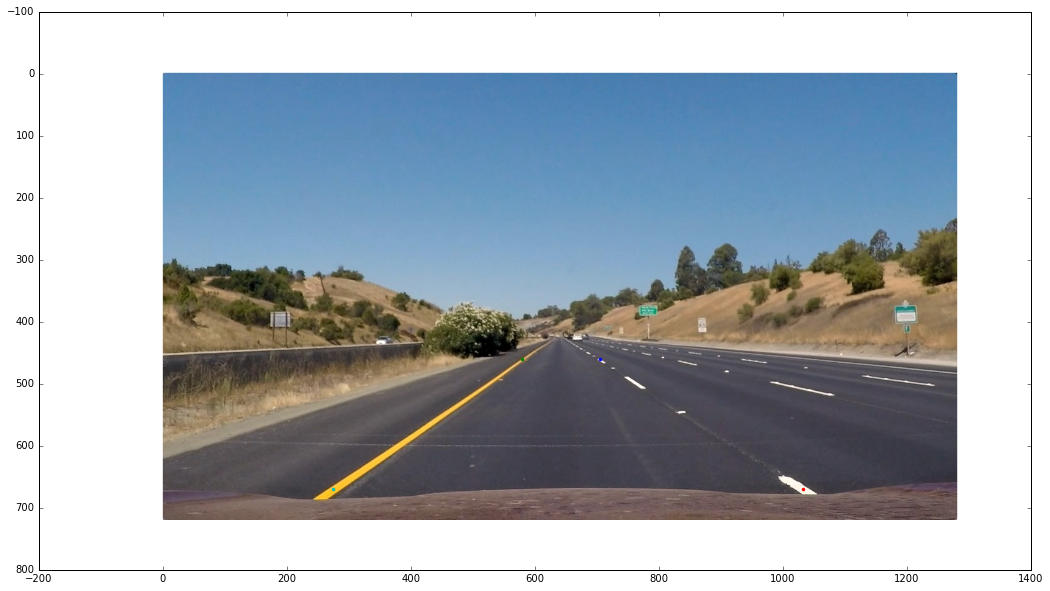

In [296]:
import matplotlib.image as mpimg

img = mpimg.imread('test_images/straight_lines1.jpg')
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.plot(705, 460, '.')
plt.plot(580, 460, '.')
plt.plot(1033, 670, '.')
plt.plot(275, 670, '.')

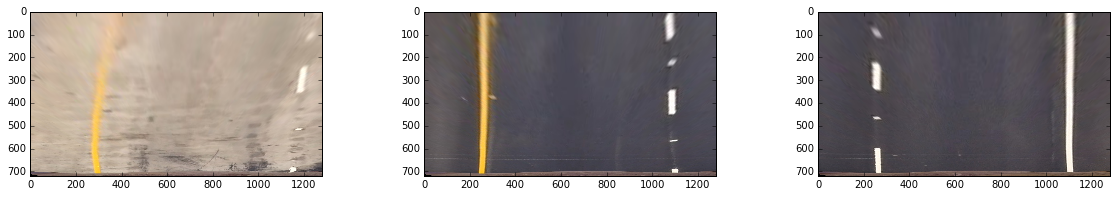

In [307]:
src_pnts = np.float32([[1033,670],          
                  [275,670],
                  [705,460],
                  [580,460]])          

dst_pnts = np.float32([[1100, 700],
                  [250, 700],
                  [1100, 0],
                  [250, 0]])
img_size = (img.shape[1], img.shape[0])
road_camera_M = cv2.getPerspectiveTransform(src_pnts, dst_pnts)
inv_road_camera_M = cv2.getPerspectiveTransform(dst, src)
img = mpimg.imread('test_images/test1.jpg')
warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.figure(figsize=(20,10))
plt.subplot(331)
plt.imshow(warped)

img2 = mpimg.imread('test_images/straight_lines1.jpg')
warped = cv2.warpPerspective(img2, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.subplot(332)
plt.imshow(warped)

img3 = mpimg.imread('test_images/straight_lines2.jpg')
warped = cv2.warpPerspective(img3, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.subplot(333)
plt.imshow(warped)


/Users/anton/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


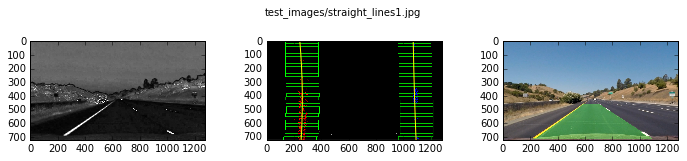

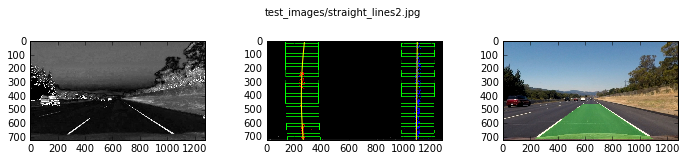

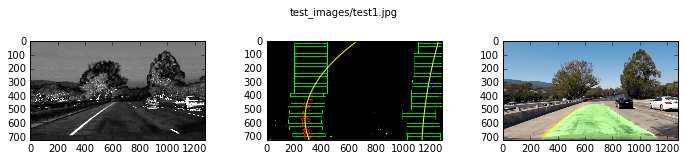

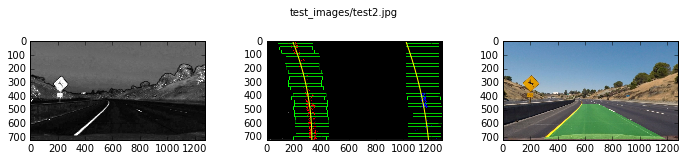

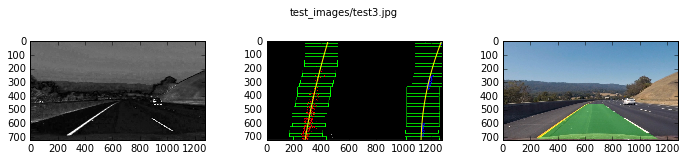

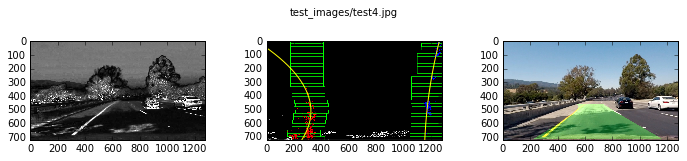

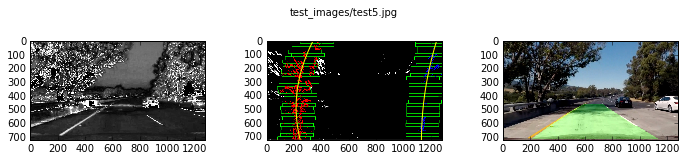

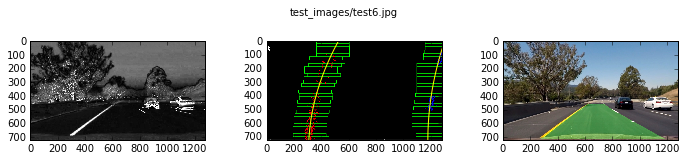

In [320]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

def window_conv(image):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    return output



# Let's build the entire pipeline at once
def pipeline_one(filename):
    img = cv2.imread(filename)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, saturation.shape[::-1], None,None)
   
    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
 
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    mag_binary = mag_threshold(warped, sobel_kernel=ksize, mag_thresh=(10, 100))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.5, 1.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(fname)
    plt.subplot(331)
    plt.imshow(saturation, cmap="gray")
 
    plt.subplot(332)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
  
    plt.subplot(333)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
    
    

images=glob.glob("test_images/*.jpg")
for idx, fname in enumerate(images):
    pipeline_one(fname)


In [324]:
# Let's build the entire pipeline at once
def movie_pipeline_one(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Saturation channel
    saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, saturation.shape[::-1], None,None)
   
    # Undistort the image
    undist_sat = cv2.undistort(saturation, mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Perform perspective transform
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist_sat, road_camera_M, img_size, flags=cv2.INTER_LINEAR)
 
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    mag_binary = mag_threshold(warped, sobel_kernel=ksize, mag_thresh=(10, 100))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.5, 1.3))

    binary_warped = np.zeros_like(saturation)
    binary_warped[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 30
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    # Create an output image to draw on and  visualize the result
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_road_camera_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
 
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(movie_pipeline_one) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
   
 

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<16:10,  1.30it/s]

  0%|          | 2/1261 [00:01<16:10,  1.30it/s]

  0%|          | 3/1261 [00:02<16:12,  1.29it/s]

  0%|          | 4/1261 [00:03<16:05,  1.30it/s]

  0%|          | 5/1261 [00:03<15:58,  1.31it/s]

  0%|          | 6/1261 [00:04<16:00,  1.31it/s]

  1%|          | 7/1261 [00:05<15:59,  1.31it/s]

  1%|          | 8/1261 [00:06<17:10,  1.22it/s]

  1%|          | 9/1261 [00:07<16:51,  1.24it/s]

  1%|          | 10/1261 [00:07<16:50,  1.24it/s]

  1%|          | 11/1261 [00:08<16:40,  1.25it/s]

  1%|          | 12/1261 [00:09<16:29,  1.26it/s]

  1%|          | 13/1261 [00:10<17:04,  1.22it/s]

  1%|          | 14/1261 [00:11<16:50,  1.23it/s]

  1%|          | 15/1261 [00:11<16:35,  1.25it/s]

  1%|▏         | 16/1261 [00:12<16:24,  1.26it/s]

  1%|▏         | 17/1261 [00:13<16:12,  1.28it/s]

  1%|▏         | 18/1261 [00:14<16:14,  1.28it/s]

  2%|▏         | 19/1261 [00:15<16:13,  1.28it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 15min 36s, sys: 49.5 s, total: 16min 26s
Wall time: 15min 17s


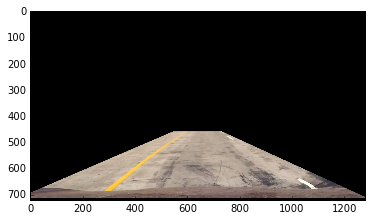